In [124]:
import numpy as np
import scipy.ndimage
plt.style.use("default")
import time

## Generating a latent space representation
To make it more "understandable" where material is placed we generate a slowly varying landscape by interpolation of a low resolution map.

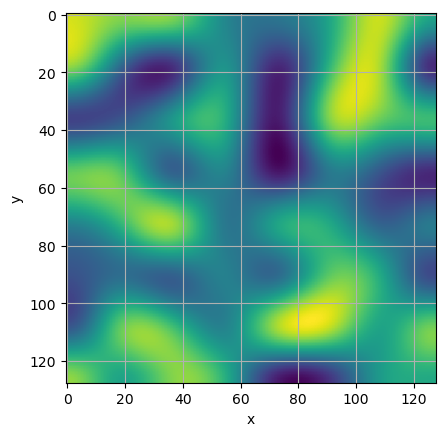

In [133]:
features = 8
zoom = 16
heatmap = np.random.random((features,features))-0.5
large_heatmap = scipy.ndimage.zoom(heatmap, zoom)
plt.imshow(large_heatmap)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

N=features*zoom

## Generating the brush

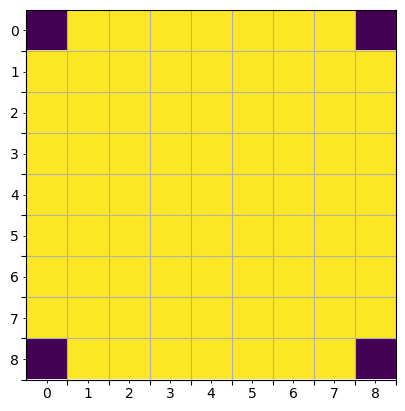

In [134]:
kernel_size=9
brush = np.ones((kernel_size, kernel_size))
brush[0,0] = 0
brush[0,-1] = 0
brush[-1,0] = 0
brush[-1,-1] = 0
brush = brush.astype(bool)

def show_brush(brush):
  nx, ny = brush.shape
  plt.imshow(brush)
  ax = plt.gca()
  ax.set_yticks(np.arange(nx)+0.5)
  ax.set_yticklabels(["" for i in range(nx)])
  ax.set_xticks(np.arange(ny)+0.5)
  ax.set_xticklabels(["" for i in range(ny)])
  ax.set_yticks(np.arange(nx), minor=True)
  ax.set_yticklabels([f"{i}" for i in range(nx)], minor=True)
  ax.set_xticks(np.arange(ny), minor=True)
  ax.set_xticklabels([f"{i}" for i in range(ny)], minor=True)
  plt.grid()

show_brush(brush)

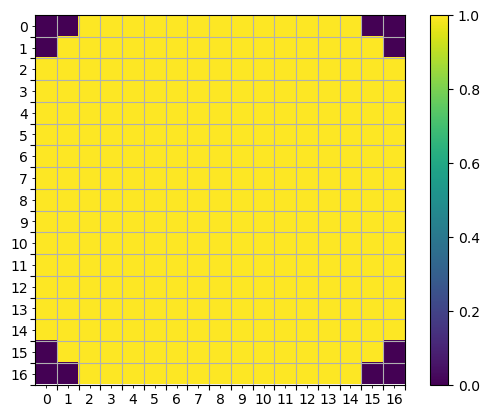

In [135]:
conv_brush = scipy.ndimage.convolve(np.pad(brush, len(brush)//2), brush)
show_brush(conv_brush)
plt.colorbar()

## Running the Generator

In [144]:
def dilate(img, brush):
    global time_dilate
    time_dilate -= time.process_time() 
    dil = scipy.ndimage.binary_dilation(img, brush)
    time_dilate += time.process_time() 
    return dil

def existing_pixels(touches, brush):
    return dilate(touches, brush)

def impossible_touches(existing_other, brush): # TODO avoid dilate
    return dilate(existing_other, brush)

def valid_touches(impossible, touches):
    return np.logical_and(np.logical_not(impossible), np.logical_not(touches))

def possible_pixels(valid, touches, brush): # TODO avoid dilate
    possible_touches = np.logical_or(touches, valid)
    return dilate(possible_touches, brush)

def required_pixels(existing, possible_other):
    return np.logical_and(np.logical_not(existing), np.logical_not(possible_other))

def resolving_touches(required, valid, brush): # TODO avoid dilate
    return np.logical_and(dilate(required, brush), valid)

def free_touches(possible_other, existing_other, valid, brush):
    dilated = dilate(np.logical_or(possible_other, existing_other), brush)
    return np.logical_and(np.logical_not(dilated), valid)


def select_single(s_valid, v_valid, s_suggest, v_suggest, brush, t_s, t_v, p_s_existing, p_v_existing, t_s_impossible, t_v_impossible):
    global time_convolute
    time_convolute -= time.process_time() 
    s_weights = scipy.ndimage.convolve(s_suggest, brush) # TODO eliminate this convolution!
    v_weights = -scipy.ndimage.convolve(v_suggest, brush)
    time_convolute += time.process_time() 

    s_weights[np.logical_not(s_valid)] = np.nan
    v_weights[np.logical_not(v_valid)] = np.nan

    max_s = max_v = -np.inf
    if s_valid.any():
        max_pos_s = np.nanargmax(s_weights)
        max_s = s_weights.flat[max_pos_s]
    
    if v_valid.any():
        max_pos_v = np.nanargmax(v_weights)
        max_v = v_weights.flat[max_pos_v]

    if  max_s > max_v:
      touch(max_pos_s, brush, t_s, p_s_existing, t_v_impossible)
    else:
      touch(max_pos_v, brush, t_v, p_v_existing, t_s_impossible)

def touch(flat_index, brush, touches, existing, other_impossible, conv_brush=conv_brush): # TODO pull up conv_brush
  """Perform a touch on the given index of the flattened map and track the consequences"""
  touches.flat[flat_index] = True
  track(existing, flat_index, brush)
  track(other_impossible, flat_index, conv_brush)

def track(existing, pos, brush):
  l = len(brush)//2
  idx = np.unravel_index(pos, existing.shape)

  # slightly complicated :/
  dw = [min(l, idx_i) for idx_i in idx] #from the brushcenter how many pixels "down" the axis
  up = [min(l+1, max(l_existing - idx_i, 0)) for (idx_i, l_existing) in zip(idx, existing.shape)]
  existing[
    idx[0]-dw[0]:idx[0]+up[0], 
    idx[1]-dw[1]:idx[1]+up[1]] |= brush[
        l -dw[0]:l     +up[0],
        l -dw[1]:l     +up[1],
    ]

debug = True
def log(*args):
  if debug:
    print(*args)

opt_track_existing = True

def generate():
  time_update = 0
  time_select = 0 
  global time_dilate
  time_dilate = 0
  global time_convolute
  time_convolute = 0
  time_existing = 0
  time_impossible = 0
  time_valid = 0
  time_possible = 0
  time_required = 0
  time_resolving = 0
  time_free = 0

  s_suggest = large_heatmap.copy()
  v_suggest = large_heatmap.copy()

  t_s = np.zeros_like(s_suggest).astype(bool)
  t_v = t_s.copy()
  p_s_existing = t_s.copy()
  p_v_existing = t_s.copy()
  t_s_impossible = t_s.copy()
  t_v_impossible = t_s.copy()

  for i in range(N**2):
      time_update -= time.process_time() 

      s_suggest[p_s_existing] = 0
      v_suggest[p_v_existing] = 0

      time_valid -= time.process_time() 
      t_s_valid = valid_touches(t_s_impossible, t_s)
      t_v_valid = valid_touches(t_v_impossible, t_v)
      time_valid += time.process_time() 

      time_possible -= time.process_time() 
      p_s_possible = possible_pixels(t_s_valid,t_s,brush)
      p_v_possible = possible_pixels(t_v_valid,t_v,brush)
      time_possible += time.process_time() 

      time_free -= time.process_time() 
      t_s_free = free_touches(p_v_possible, p_v_existing, t_s_valid, brush)
      t_v_free = free_touches(p_s_possible, p_s_existing, t_v_valid, brush)
      time_free += time.process_time() 

      if not(t_s_free.any() or t_v_free.any()): # only required if no fre touches are available
        time_required -= time.process_time() 
        p_s_required = required_pixels(p_s_existing, p_v_possible)
        p_v_required = required_pixels(p_v_existing, p_s_possible)
        time_required += time.process_time() 

        time_resolving -= time.process_time() 
        t_s_resolving = resolving_touches(p_s_required, t_s_valid, brush)
        t_v_resolving = resolving_touches(p_v_required, t_v_valid, brush)
        time_resolving += time.process_time() 

      time_update += time.process_time() 
      time_select -= time.process_time() 

      if t_s_free.any() or t_v_free.any():
          log(f"{i}: free: {t_s_free.sum()}; {t_v_free.sum()}")

          flat_free_s = np.where(t_s_free.flatten())[0]
          flat_free_v = np.where(t_v_free.flatten())[0]
          
          time_existing -= time.process_time() 
          for idx in flat_free_s:
            touch(idx, brush, t_s, p_s_existing, t_v_impossible)
          
          for idx in flat_free_v:
            touch(idx, brush, t_v, p_v_existing, t_s_impossible)
          time_existing += time.process_time() 

      elif t_s_resolving.any() or t_v_resolving.any():
          log(f"{i}: resolving")
          #p_s_existing, p_v_existing, t_s, t_v = 
          select_single(
            t_s_resolving, t_v_resolving, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing, t_s_impossible, t_v_impossible)
      elif t_s_valid.any() or t_v_valid.any():
          log(f"{i}: valid")
          #p_s_existing, p_v_existing, t_s, t_v = 
          select_single(
            t_s_valid, t_v_valid, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing, t_s_impossible, t_v_impossible)
      else:
          print("finished")
          time_select += time.process_time() 
          break

      time_select += time.process_time() 

  plt.figure(figsize = (6,6))
  plt.subplot(221)
  plt.title("Solid and Void")
  plt.imshow(p_s_existing)
  plt.subplot(222)
  plt.title("Solid and Void Touches")
  plt.imshow(t_s.astype(int)-t_v)
  plt.subplot(223)
  plt.imshow(large_heatmap)

  return dict(
    update = time_update,
    select = time_select,
    dilate = time_dilate,
    existing = time_existing,
    impossible = time_impossible,
    valid = time_valid,
    possible = time_possible,
    required = time_required,
    resolving = time_resolving,
    free = time_free,
    convolute = time_convolute
  )

0: valid
1: valid
2: valid
3: valid
4: resolving
5: free: 16; 0
6: valid
7: valid
8: resolving
9: free: 0; 17
10: valid
11: resolving
12: free: 17; 0
13: valid
14: free: 0; 11
15: valid
16: valid
17: resolving
18: free: 19; 0
19: resolving
20: free: 52; 0
21: valid
22: resolving
23: free: 9; 0
24: valid
25: resolving
26: free: 65; 0
27: valid
28: free: 19; 0
29: valid
30: valid
31: resolving
32: free: 0; 17
33: valid
34: free: 0; 8
35: valid
36: free: 0; 8
37: valid
38: free: 0; 11
39: valid
40: resolving
41: free: 0; 25
42: valid
43: free: 8; 0
44: valid
45: valid
46: valid
47: free: 65; 0
48: valid
49: resolving
50: free: 0; 21
51: valid
52: valid
53: resolving
54: resolving
55: free: 64; 0
56: resolving
57: free: 13; 0
58: valid
59: free: 26; 0
60: valid
61: valid
62: free: 38; 0
63: valid
64: resolving
65: free: 39; 0
66: valid
67: valid
68: free: 0; 14
69: valid
70: resolving
71: free: 0; 62
72: valid
73: free: 0; 9
74: valid
75: free: 34; 0
76: valid
77: valid
78: valid
79: resol

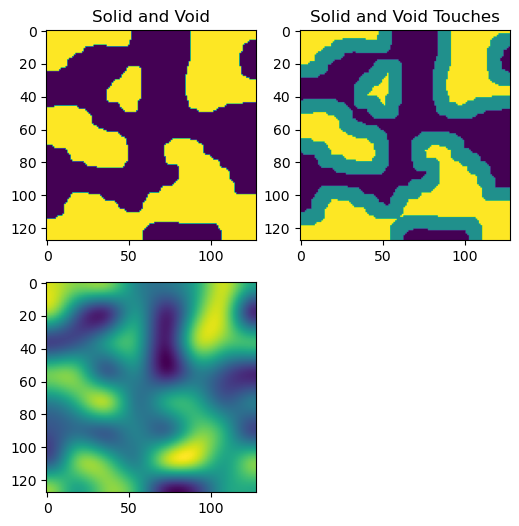

In [145]:
times = generate()

In [142]:
times["update"]+times["select"]

3.4500029999998674

No tracking: 6.94s

With tracking: 6.09s

With full tracking: 5.72s

In [143]:
times

{'update': 2.549186000000418,
 'select': 0.9008169999994493,
 'dilate': 2.4949370000017552,
 'existing': 0.15856199999910814,
 'impossible': 0,
 'valid': 0.007093999998801337,
 'possible': 0.8815540000002215,
 'required': 0.003707000000019889,
 'resolving': 1.0125799999999572,
 'free': 0.6228959999999688,
 'convolute': 0.6524089999996932}